
Group 11

Ziqiang Li, 1173898

Donghao Yang, 1514687

Rui Mao, 1469805

Xiaxuan Du, 1481272

Ruoyu Lu, 1466195


In [108]:
import json
from collections import defaultdict
import re
import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pytz

## Data Process

### get data from ES

In [109]:
import requests
import json

def getdata(index, data):
    url = f"https://127.0.0.1:9200/{index}/_search"
    headers = {
        "Content-Type": "application/json"
    }
    auth = ("elastic", "elastic")
    response = requests.get(url, headers=headers, json=data, auth=auth, verify=False) 
    return response.json()


In [110]:
index = 'sentiment*'
data = {
    "size" : 2000,
    "query": {
        "bool": {
            "must": [
                {
                    "match": {
                        "country": "au"
                    }
                }
            ]
        }
    }
}
json_response = getdata(index,data)
sentiments_au = json_response['hits']['hits']
sentiments_total = json_response['hits']['total']['value']

/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [111]:
sentiments_gccsa = defaultdict(list)
for sentiment in sentiments_au:
    gccsa = sentiment['_source']['gccsa']
    if gccsa not in sentiments_gccsa:
        sentiments_gccsa[gccsa]=[0, 0]
    sentiments_gccsa[gccsa][0] += sentiment['_source']['sentiment']
    sentiments_gccsa[gccsa][1] += sentiment['_source']['sentimentcount']


In [112]:
index = 'weather*'
# size: the max size limit of data returned
data = {
    "size" : 1000,
}

json_response = getdata(index,data)
weather = json_response['hits']['hits']

/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [113]:

index = 'air*'
# size: the max size limit of data returned
data = {
    "size" : 1000,
}

json_response = getdata(index,data)

air = json_response['hits']['hits']


/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [114]:
index = 'crash*'
# size: the max size limit of data returned
data = {
    "size" : 1000,
}

json_response = getdata(index,data)

crash = json_response['hits']['hits']


/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [115]:
index = 'income*'
# size: the max size limit of data returned
data = {
    "size" : 1000,
}

json_response = getdata(index,data)

income = json_response['hits']['hits']

/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [116]:
import requests
# request for sum of sentiments in Aus
url = "http://127.0.0.1:9090/sentiments/country/au/field/sentiment"
# request for sum of sentimentcount in Aus
url_num = "http://127.0.0.1:9090/sentiments/country/au/field/sentimentcount"

response = requests.get(url)
response1 = requests.get(url_num)

if response1.status_code == 200:
    json_data1 = response1.json()
    formatted_json1 = json.dumps(json_data1, indent=4)
    print(formatted_json1)
else:
    print("Error:", response.status_code)
if response.status_code == 200:
    json_data = response.json()
    formatted_json = json.dumps(json_data, indent=4)
    print(formatted_json)
else:
    print("Error:", response.status_code)
    


{
    "sum_sentiment": {
        "value": 325354.0
    }
}
{
    "sum_sentiment": {
        "value": 34041.92032577284
    }
}


In [117]:
who_average_sen=list(list(json_data.values())[0].values())[0]/list(list(json_data1.values())[0].values())[0]

### crash

In [118]:
crash_dict=defaultdict(dict)
for crash_time in crash:
    crash_index=defaultdict(dict)
    crash_index["light_condition"]=crash_time["_source"]["light_condition"]
    crash_index["severity"]=crash_time["_source"]["severity"]
    crash_index["speed_zone"]=crash_time["_source"]["speed_zone"]
    date_time_obj = datetime.strptime(crash_time["_source"]["crash_date"], "%Y-%m-%dT%H:%M:%S.%f%z")
    formatted_date = date_time_obj.strftime("%y-%m-%d-%H-%M-%S")
    
    crash_dict[formatted_date]=crash_index
sorted_crash = {k: crash_dict[k] for k in sorted(crash_dict)}

In [119]:
crash_date_dict=defaultdict(int)
for key in sorted_crash.keys():
    date_part = "-".join(key.split("-")[:3])
    crash_date_dict[date_part]+=1


In [120]:
light_dict=defaultdict(int)
sever_dict=defaultdict(int)
speed_dict=defaultdict(int)
for i in sorted_crash.values():
    light_dict[i["light_condition"]]+=1
    sever_dict[i["severity"]]+=1
    speed_dict[i["speed_zone"]]+=1

### weather

In [121]:
def process_weather(weather):
    weather_dict=defaultdict(dict)
    for weather_time in weather:
        weather_index=defaultdict(dict)
        if weather_time["_source"]["name"]=="Ballarat":
            weather_index["apparent_t"]=weather_time["_source"]["apparent_t"]
            weather_index["cloud"]=weather_time["_source"]["cloud"]
            weather_index["air temperature"]=weather_time["_source"]["air_temp"]
            weather_index["visibility"]=int(weather_time["_source"]["vis_km"])
            weather_index["wind speed"]=weather_time["_source"]["wind_spd_kmh"]
            date_time_obj = datetime.strptime(weather_time["_source"]["aifstime_utc"], "%Y%m%d%H%M%S")
            date_time_obj = date_time_obj.replace(tzinfo=pytz.UTC)
            melbourne_tz = pytz.timezone('Australia/Melbourne')
            melbourne_time = date_time_obj.astimezone(melbourne_tz)
            formatted_date = melbourne_time.strftime("%y-%m-%d-%H-%M-%S")
            weather_dict[formatted_date]=weather_index
    sorted_weather = {k: weather_dict[k] for k in sorted(weather_dict)}
    return sorted_weather

### air

In [122]:
def process_air(air):
    air_dict=defaultdict(dict)
    for air_time in air:
    
        date_time_obj = datetime.strptime(air_time["_source"]["date_time"], "%Y-%m-%dT%H:%M:%S%z")
        date_time_obj = date_time_obj.replace(tzinfo=pytz.UTC)
        melbourne_tz = pytz.timezone('Australia/Melbourne')
        melbourne_time = date_time_obj.astimezone(melbourne_tz)
        formatted_date = melbourne_time.strftime("%y-%m-%d-%H-%M-%S")
    
        year = date_time_obj.year
    #print(type(year))
        if year==2024:
            air_index=defaultdict(dict)
            air_index["pm 1"]=air_time["_source"]["pm1"]
            air_index["pm 10"]=air_time["_source"]["pm10"]
            air_index["pm 25"]=air_time["_source"]["pm25"]
            air_index["ozone"]=air_time["_source"]["ozone"]
            air_index["NO2"]=air_time["_source"]["nitrogen_dioxide"]
            air_index["CO"]=air_time["_source"]["carbon_monoxide"]
            air_index["air quality"]=air_time["_source"]["air_quality_category"]
            air_dict[formatted_date]=air_index
    sorted_air= {k: air_dict[k] for k in sorted(air_dict)}
    return(sorted_air)

In [123]:
def air_line_chart(sorted_air):
    filtered_air=defaultdict(dict)
    for keys, air_time in sorted_air.items():
        for key, value in air_time.items():
            if key != "air quality":
                filtered_air[keys][key]=value
    group_line_chart(filtered_air)

In [124]:
def weather_line_chart(sorted_weather):
    filtered_weather=defaultdict(dict)
    for keys, weather_time in sorted_weather.items():
        for key, value in weather_time.items():
            if key != "cloud":
                filtered_weather[keys][key]=value
    group_line_chart(filtered_weather)

In [125]:
def cloud(sorted_weather):
    cloud_weather=defaultdict(dict)
    for keys, weather_time in sorted_weather.items():
        for key, value in weather_time.items():
            if key == "cloud":
                    cloud_weather[keys]=value
    table(cloud_weather,"cloud")

In [126]:
from itertools import islice
def quality(sorted_air):
    quality_air=defaultdict(dict)
    for keys, air_time in sorted_air.items():
        for key, value in air_time.items():
            if key == "air quality":
                quality_air[keys]=value
    last_20_items = dict(islice(quality_air.items(), len(quality_air) - 20, len(quality_air)))
    table(last_20_items,"air quality")

In [127]:
import pandas as pd


def table(cloud_weather,title):
    records = []
    for datetime_str, sensors in cloud_weather.items():
        record = {'datetime': datetime.strptime(datetime_str, '%y-%m-%d-%H-%M-%S')}
        sensors={title:sensors}
        #print(sensors)
        record.update(sensors)
        records.append(record)
    df = pd.DataFrame(records )

    df['datetime'] = pd.to_datetime(df['datetime'], format='%y-%m-%d-%H-%M-%S')

    df.set_index('datetime', inplace=True)

    print(df)


### sentiment

In [128]:
import requests
import json

url = "https://127.0.0.1:9200/sentiments*/_search"
headers = {
    "Content-Type": "application/json"
}
data = {
    "size" : 2000,
    "query": {
        "bool": {
            "must": [
                {
                    "match": {
                        "country": "au"
                    }
                }
            ]
        }
    }
}
auth = ("elastic", "elastic")

response = requests.get(url, headers=headers, json=data, auth=auth, verify=False) # 设置verify=False以忽略SSL证书验证
json_response = response.json()

# with open("search_results.json", "w") as json_file:
#     json.dump(json_response, json_file)

# print(type(json_response))

sentiments_au = json_response['hits']['hits']
sentiments_total = json_response['hits']['total']['value']

/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### income

In [129]:

area_values=defaultdict(list)

    
for income_time in income:
    area=income_time["_source"]["gccsa_code_2021"]
    income_totals =defaultdict(int)
    age_totals = defaultdict(int)
    for key, value in income_time["_source"].items():
        parts = key.split('_')
            #print(parts[1],parts[-1])
        if parts[0]=="tot" and parts[-1]=="tot":
                #print(parts[1])
            if parts[1].isnumeric() and parts[2].isnumeric():
                    #print(1)
                income_key = parts[1]+"_"+parts[2]#'_'.join(part for part in parts[1:] if part.isnumeric() or part.endswith('mo') )
            elif parts[1].endswith('mo'):
                income_key = parts[1]
                # if income_key not in income_totals:
                #     income_totals[income_key] = 0
                #print(income_key)
            income_totals[income_key] = int(value)
        if 'a' in parts:
            age_index = parts.index('a') + 1
            age_key = '_'.join(parts[age_index:age_index+2])
            if age_key not in age_totals:
                age_totals[age_key] = 0
            age_totals[age_key] += int(value)
    area_values[area]=[income_totals,age_totals]

### income-age pair

In [130]:
income_by_age = defaultdict(dict)
for income_time in income:
    aream=income_time["_source"]["gccsa_code_2021"]
    if aream=="2GMEL":
        
        for key, value in income_time["_source"].items():
        #print(key, value)
            if "_a_" not in key:
                continue
    
            income_range = re.findall(r'tot_\d+_\d+_a|tot_\d+mo_a', key)
            age_group = re.findall(r'a_\d+_\d+', key)
    
            if income_range and age_group:
                income_range = income_range[0][4:]#.replace('_', ' to ')
                income_range = income_range[:-2]
                age_group = age_group[0][2:]#.replace('_', ' to ')
                income_by_age[age_group][income_range] = value

In [131]:
def extract_number(text):
    numbers = re.findall(r'\d+', text)
    if numbers:
        return int(numbers[0])
    return 0  

In [132]:
income_ranges = []
for age1 in income_by_age.keys():
    for income1 in income_by_age[age1]:
        income_ranges.append(income1)
income_ranges=set(income_ranges)
income_tanges=sorted(income_ranges,key=extract_number)

In [133]:
income_matrix = []
for age in sorted(income_by_age, key=extract_number):
    row=[]
    for i in income_ranges:
        if i not in income_by_age[age]:
            row.append(0)
        else:
            row.append(income_by_age[age].get(i, 0) )#for income_range in sorted(income_by_age[age], key=extract_number)]
    income_matrix.append(row)


income_matrix = np.array(income_matrix)

age_labels = sorted(income_by_age)
income_labels = income_ranges#sorted(income_by_age[age_labels[-2]],key=extract_number)


### total income & average income

In [134]:
total_income=defaultdict(float)
average_income=defaultdict(float)
for key, values in area_values.items():
    population=0
    for keys,num in values[0].items():
        population+=num
        if not keys.endswith('mo'):
            range_income=keys.split('_')
            ave_income=(int(range_income[0])+int(range_income[1]))/2
        else:
            ave_income=int(keys.replace("mo", ""))
        total_income[key]+= ave_income*num
        average_income[key]=total_income[key]/population

## Sentiment

In [135]:
# sentiments_gccsa = {gccsa: [sentiment,sentiment_count]}
sentiments_gccsa = defaultdict(list)
for sentiment in sentiments_au:
    gccsa = sentiment['_source']['gccsa']
    if gccsa not in sentiments_gccsa:
        sentiments_gccsa[gccsa]=[0, 0]
    sentiments_gccsa[gccsa][0] += sentiment['_source']['sentiment']
    sentiments_gccsa[gccsa][1] += sentiment['_source']['sentimentcount']


In [136]:
average_sentiment=defaultdict(float)
for key, value in sentiments_gccsa.items():
    if key==None:
        average_sentiment['None']=value[0]/value[1]
    else:
        average_sentiment[key]=value[0]/value[1]
sorted_average_sentiment = {key: average_sentiment[key] for key in sorted(average_sentiment)}

## Visualization

### Stacked Column Chart

In [137]:
def stacked_column_chart(data):
    income_levels = {key for region in data.values() for key in region.keys()}
    income_levels=sorted(income_levels, key=extract_number)
    regions = sorted(list(data.keys()))
    income_data = [np.array([data[region].get(level, 0) for region in regions]) for level in income_levels]
    bottom = np.zeros(len(regions))
    
    for idx, income in enumerate(income_data):
        plt.bar(regions, income, bottom=bottom, label=f" {income_levels[idx]}")
        bottom += income
    plt.legend()
    plt.title("people's income(weekly) in different areas")
    plt.xlabel('areas')
    plt.ylabel('poopulation')
    plt.show()

In [138]:
area_population=defaultdict(dict)
for key, values in area_values.items():
    area_population[key]=values[0]

### Group bar chart

In [139]:
"""
{'150_299': [50377, 33814, 67601, 21216, 32258, 32799, 20296, 5222, 31742, 6549, 3337, 3999, 1343, 1147, 6074, 55, 0],
'300_399': [56983, 37291, 70795, 22673, 32676, 34577, 20383, 5579, 31673, 7021, 3635, 4588, 1322, 936, 5144, 60, 0],
'400_499': [2386255, 1133313, 2376630, 649447, 1194277, 1117626, 636434, 158722, 972128, 274718, 117521, 122822, 72253, 35981, 266483, 2627, 0]}
"""
def group_bar_chart(data):
    regions = list(data.keys())
    income_levels = set(key for region in data.values() for key in region.keys())

    if isinstance(list(income_levels)[0], str):
        income_levels = sorted(income_levels, key=extract_number)
    else:
        income_levels = sorted(income_levels)

    bar_data = {level: [data[region].get(level, 0) for region in regions] for level in income_levels}
    #print(bar_data)
    x = np.arange(len(regions))  
    width = 0.1  

    fig, ax = plt.subplots(figsize=(14, 8)) 

    for i, level in enumerate(income_levels):
        ax.bar(x + 3*i * width/5, bar_data[level], width, label=level)

    ax.set_xlabel('Region')
    ax.set_ylabel('Number of People')
    ax.set_title('Number of People by Income Level and Region')
    ax.set_xticks(x + width/2  * len(income_levels))
    ax.set_xticklabels(regions)
    ax.legend(title="Income Levels")

    plt.xticks(rotation=45) 
    plt.show()


In [140]:
area_sentiment_income=defaultdict(dict)
income_aver=defaultdict(dict)
for keys, values in average_income.items():
    
    area_sentiment_income[keys]={"average income":values,"average sentiment":sorted_average_sentiment[keys.lower()]}

### bi group chart

In [141]:
#input example
"""
defaultdict(<class 'list'>, {'1GSYD': {'average income': 1023.1634143550161, 'average sentiment': 0.09841686491040112}, 
'1RNSW': {'average income': 865.5741380784584, 'average sentiment': 0.1181394139775494}, 
'2GMEL': {'average income': 958.9970007771568, 'average sentiment': 0.10146330736921133}, 
'2RVIC': {'average income': 841.7751051660125, 'average sentiment': 0.09425317008163572}, 
"""

def bi_group_bar_chat(sentiment_income):
    incomes = [info['average income'] for info in sentiment_income.values()]
    sentiments = [info['average sentiment'] for info in sentiment_income.values()]
    regions = sorted(sentiment_income.keys(), key=extract_number)
    x = np.arange(len(regions))  
    width = 0.4  
    fig, ax1 = plt.subplots()
    rects1 = ax1.bar(x - width/2, incomes, width, label='Average Income', color='b')

    ax2 = ax1.twinx()
    rects2 = ax2.bar(x + width/2, sentiments, width, label='Average Sentiment', color='r')

    ax1.set_xlabel('Region')
    ax1.set_ylabel('Average Income', color='b')
    ax2.set_ylabel('Average Sentiment', color='r')
    ax1.set_title('Average Income and Sentiment by Region')
    ax1.set_xticks(x)
    ax1.set_xticklabels(regions, rotation=45)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.show()


### Bar chart

In [142]:
# data: dict
def bar_chart(data):
    categories=data.keys() 
    values=data.values()
    plt.bar(categories, values, color='blue')  

    plt.title('average sentiment in Australia')  
    plt.xlabel('Areas')  
    plt.ylabel('average sentiment')  

    plt.show() 

### sub bar chart 

In [143]:
"""
{ "040": "1752.0",
    "050": "23847.0",}
{
    "Darkness (with street light)": "13087.0",
    "Darkness (without street light)": "13087.0",
}
{
    "Fatal": "328.0",
    "First Aid": "4872.0",
"""
def sub_bar_chart(speed,sev,light):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].bar(json.loads(speed).keys(), [float(value) for value in json.loads(speed).values()], color='b')
    axs[0].set_title('Speed Zones')
    axs[0].set_ylabel('Number of Accidents')
    axs[0].tick_params(axis='x', rotation=45)

    axs[1].bar(json.loads(sev).keys(), [float(value) for value in json.loads(sev).values()], color='r')
    axs[1].set_title('Light Conditions')
    axs[1].set_ylabel('Number of Accidents')
    axs[1].tick_params(axis='x', rotation=45)

    axs[2].bar(json.loads(light).keys(), [float(value) for value in json.loads(light).values()], color='g')
    axs[2].set_title('Accident Severity')
    axs[2].set_ylabel('Number of Accidents')
    axs[2].tick_params(axis='x', rotation=45)


### group line chart

In [144]:
"""
{'24-05-18-23-48-22': defaultdict(<class 'dict'>,
{'pm 1': 1, 'pm 10': 1, 'pm 25': 1, 'ozone': 61, 'NO2': 112, 'CO': -5466, 'air quality': 'Fair'})
"""
def group_line_chart(sorted_weather):
    labels=sorted_weather[list(sorted_weather.keys())[0]].keys()
    records = []
    for datetime_str, sensors in sorted_weather.items():
        record = {'datetime': datetime.strptime(datetime_str, '%y-%m-%d-%H-%M-%S')}
        record.update(sensors)
        #print(sensors)
        records.append(record)
    nrow=np.ceil(len(labels) / 1).astype(int)
    df = pd.DataFrame(records)
    df.set_index('datetime', inplace=True)  

    fig, axs = plt.subplots(nrows=nrow, ncols=1, figsize=(14, 10))
    axs = axs.flatten()  

    #pollutants = ['pm 1', 'pm 10', 'pm 25', 'ozone', 'NO2', 'CO']
    for i, pollutant in enumerate(labels):
        axs[i].plot(df.index, df[pollutant], marker='o', label=pollutant)
        #print(df[pollutant])
        axs[i].set_title(f'Trend of {pollutant}')
        axs[i].set_xlabel('Datetime')
        axs[i].set_ylabel('Value')
        axs[i].grid(True)
        axs[i].legend()

    plt.tight_layout()
    plt.show()


### Heatmap

In [145]:
def heatmap(data,x,y):
    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.imshow(data, cmap='viridis', interpolation='nearest')

    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Number of People')

    ax.set_title('Heatmap of People by Income Range and Age Group')
    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))
    ax.set_xticklabels(x)
    ax.set_yticklabels(y)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.show()

### Pie Chart

In [146]:
import matplotlib.pyplot as plt
from collections import defaultdict

def pie_chart(area_population,x,y):
    fig, axs = plt.subplots(x, y, figsize=(20, 20))
    categories = sorted(list(area_population.keys()))
    values_list = list(area_population.values())
    for i in range(4):
        for j in range(4):
            idx = i * 4 + j
            if idx < len(categories):
                category = categories[idx]
                values = values_list[idx]
                labels = list(values.keys())
                sizes = list(values.values())
                axs[i, j].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
                axs[i, j].set_title(category)
                axs[i, j].axis('equal')  
            else:
                axs[i, j].axis('off')  
    plt.tight_layout()
    plt.show()

# show

## weather air

In [149]:
#def show_weather_air():
index = 'weather*'
    # size: the max size limit of data returned
data = {
"size" : 1000,
}

json_response = getdata(index,data)
weather = json_response['hits']['hits']
#print(weather)

    
index = 'air*'
    # size: the max size limit of data returned
data = {
"size" : 1000,
}

json_response = getdata(index,data)

air = json_response['hits']['hits']
sorted_weather=process_weather(weather)
sorted_air=process_air(air)


/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/ruimao/miniconda3/envs/python38/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


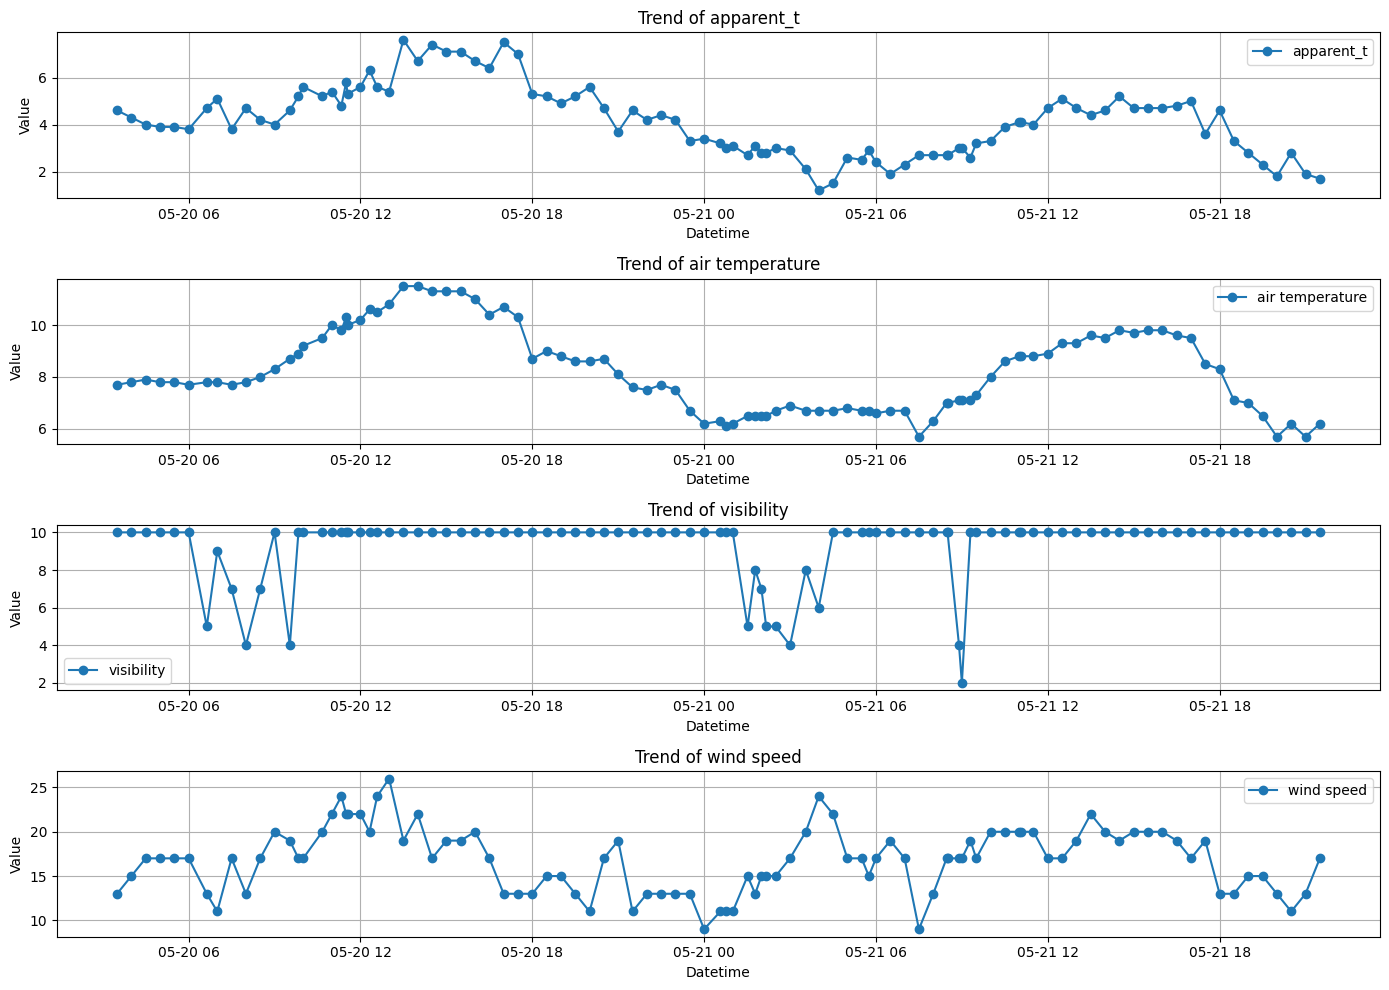

In [150]:
weather_line_chart(sorted_weather)

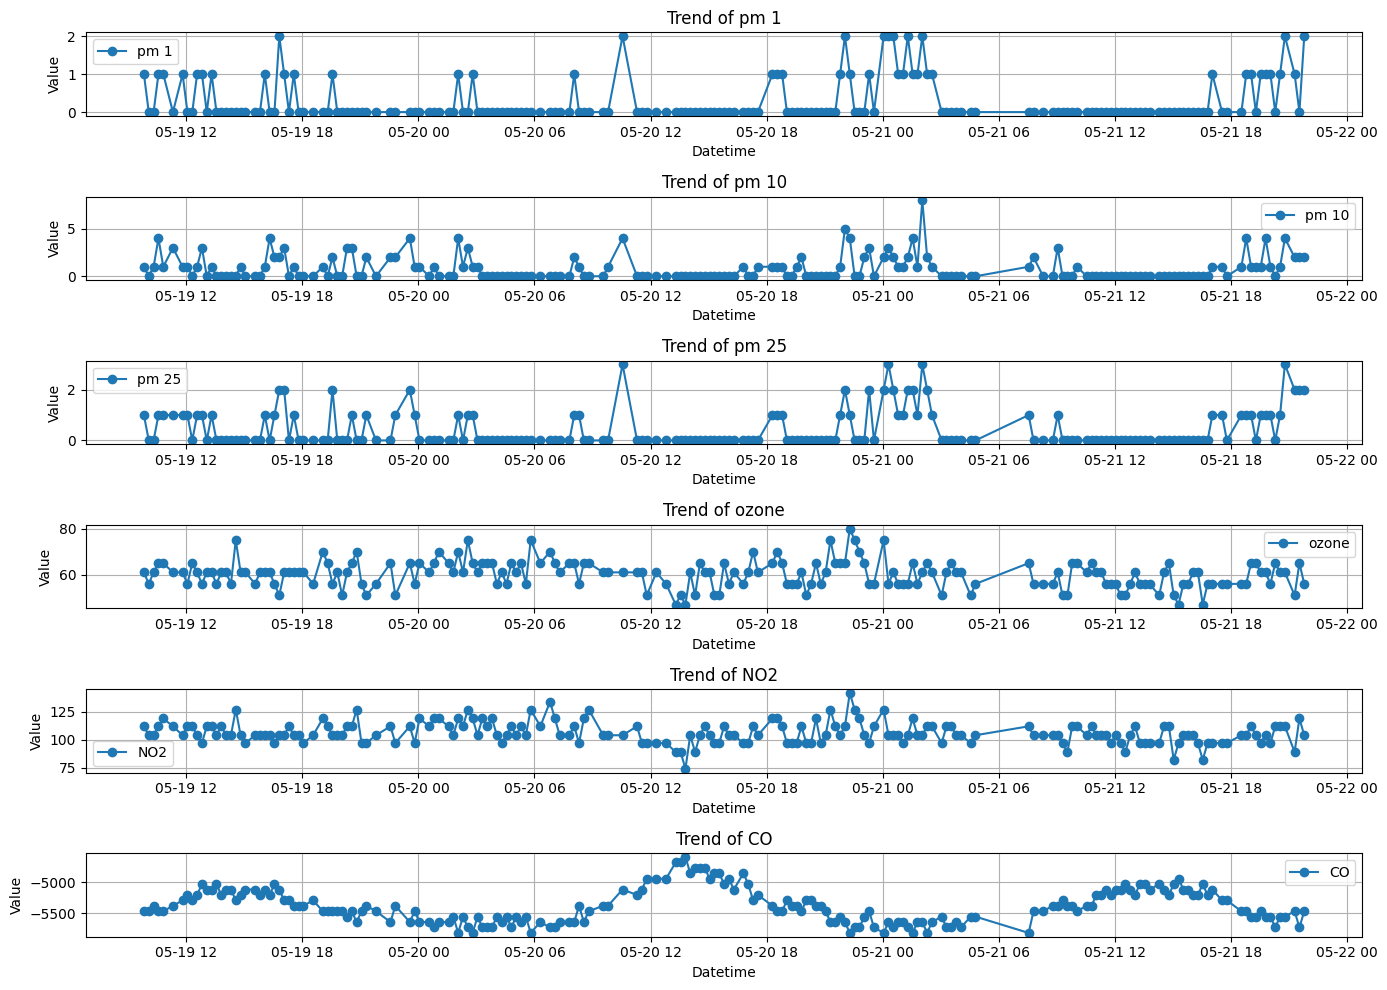

In [151]:
air_line_chart(sorted_air)

In [152]:
quality(sorted_air)

                    air quality
datetime                       
2024-05-21 16:03:06        Fair
2024-05-21 16:17:59        Fair
2024-05-21 16:33:06        Fair
2024-05-21 16:47:59        Fair
2024-05-21 17:02:59        Fair
2024-05-21 17:32:59        Fair
2024-05-21 17:47:59        Fair
2024-05-21 18:32:58        Fair
2024-05-21 18:47:58        Fair
2024-05-21 19:02:58        Fair
2024-05-21 19:17:58        Fair
2024-05-21 19:32:58        Fair
2024-05-21 19:47:58        Fair
2024-05-21 20:03:04        Fair
2024-05-21 20:17:58        Fair
2024-05-21 20:32:57        Fair
2024-05-21 20:47:58        Fair
2024-05-21 21:18:05        Fair
2024-05-21 21:32:58        Fair
2024-05-21 21:47:58        Fair


In [153]:
cloud(sorted_weather)


                             cloud
datetime                          
2024-05-20 03:30:00         Cloudy
2024-05-20 04:00:00         Cloudy
2024-05-20 04:30:00  Partly cloudy
2024-05-20 05:00:00         Cloudy
2024-05-20 05:30:00         Cloudy
...                            ...
2024-05-21 19:30:00              -
2024-05-21 20:00:00  Partly cloudy
2024-05-21 20:30:00         Cloudy
2024-05-21 21:00:00  Mostly cloudy
2024-05-21 21:30:00         Cloudy

[97 rows x 1 columns]


## income

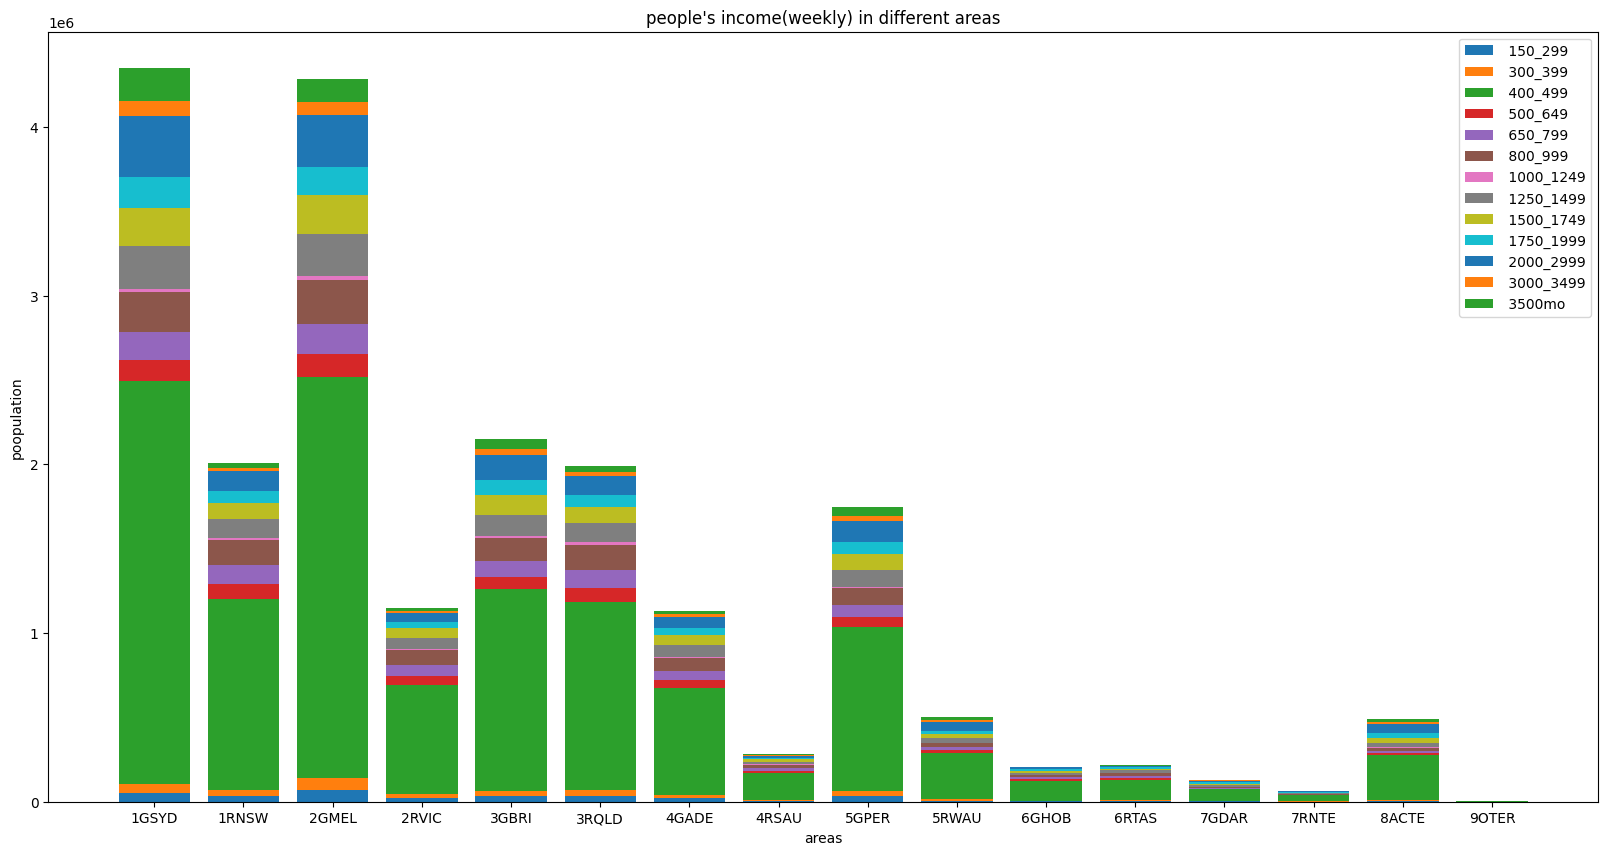

In [154]:
plt.figure(figsize=(20, 10))
stacked_column_chart(area_population)

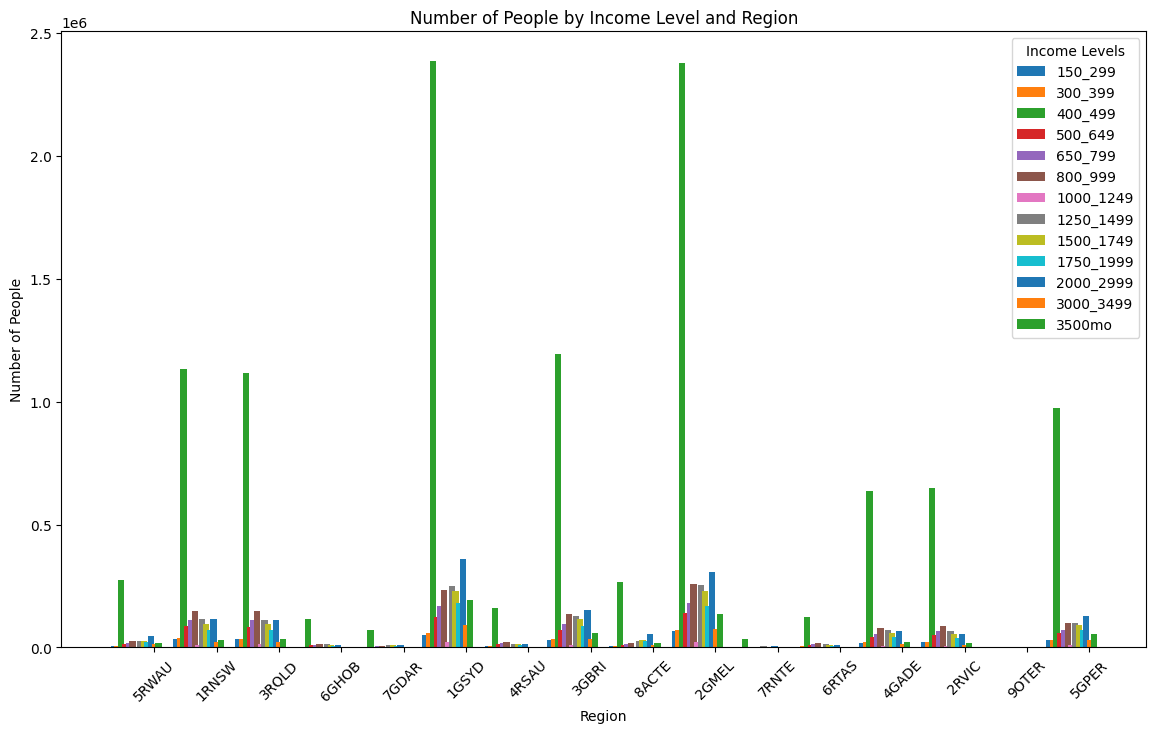

In [155]:
group_bar_chart(area_population)

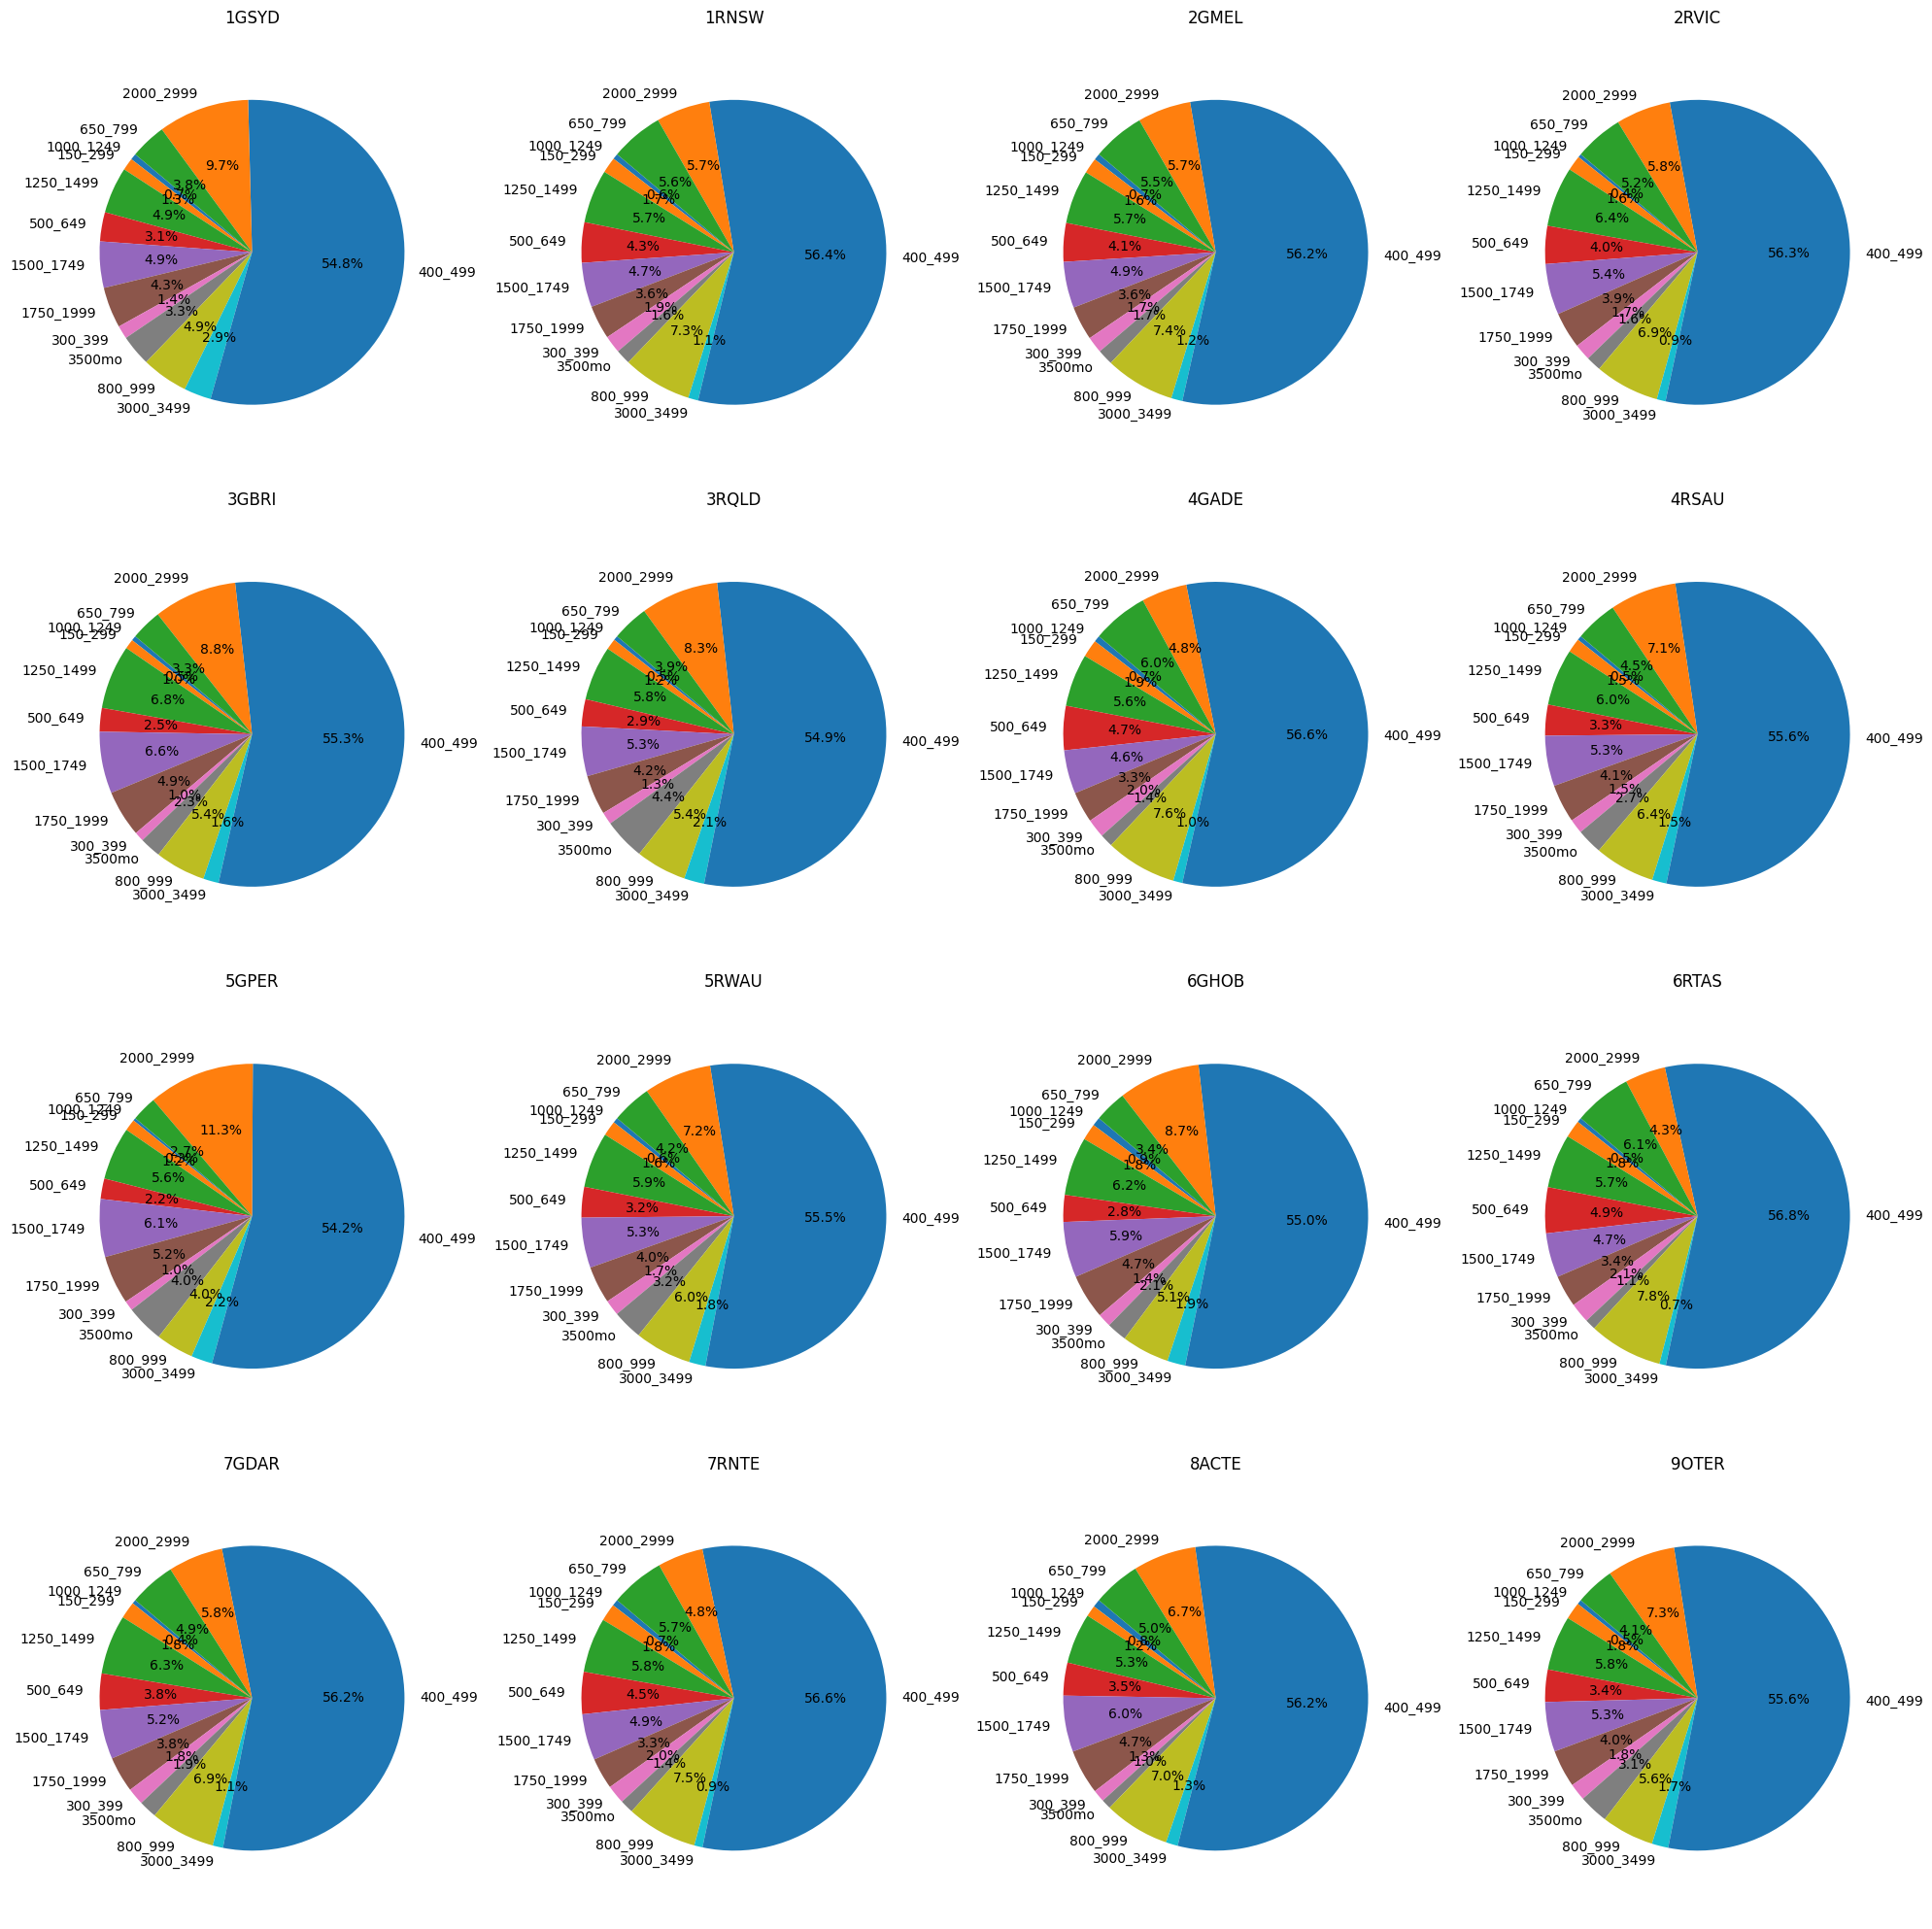

In [156]:
pie_chart(area_population,4,4)

## income and age in Melbourne

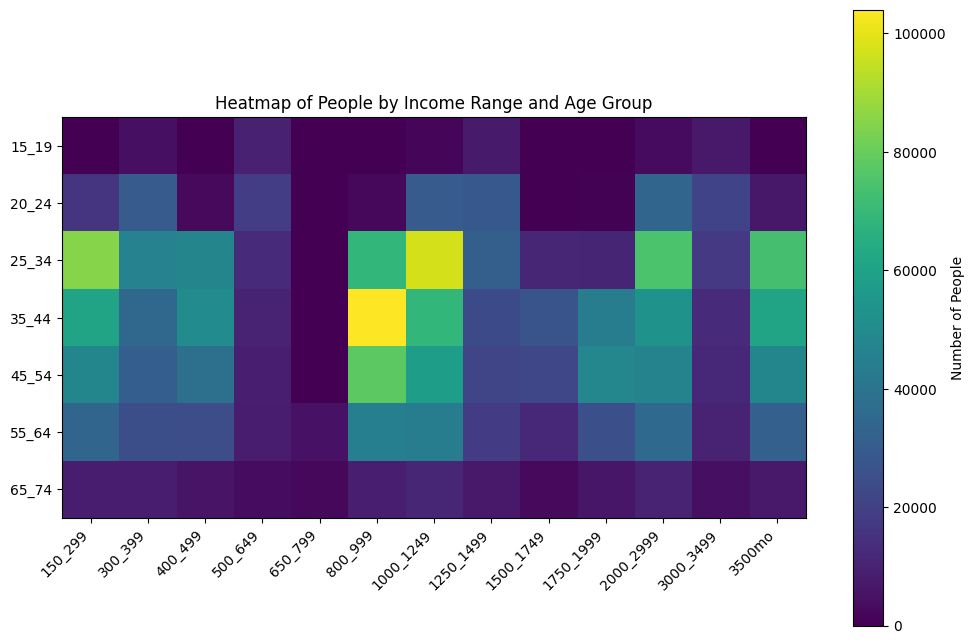

In [157]:
heatmap(income_matrix,sorted(income_labels,key=extract_number),age_labels)

## sentiment

{'1gsyd': 0.09869825811610333, '1rnsw': 0.1170300818715242, '2gmel': 0.10208097605964377, '2rvic': 0.0952145150915211, '3gbri': 0.10794952010098323, '3rqld': 0.09468151900545832, '4gade': 0.11040281586642078, '4rsau': 0.07601337816442919, '5gper': 0.10068095417456427, '5rwau': 0.11991379897246912, '6ghob': 0.14416647967990476, '6rtas': 0.08524820107708456, '7gdar': 0.09823621686640098, '7rnte': 0.12988036830005142, '8acte': 0.11285173523274795, '9oter': 0.14150430401931, 'None': 0.11255667433826244}


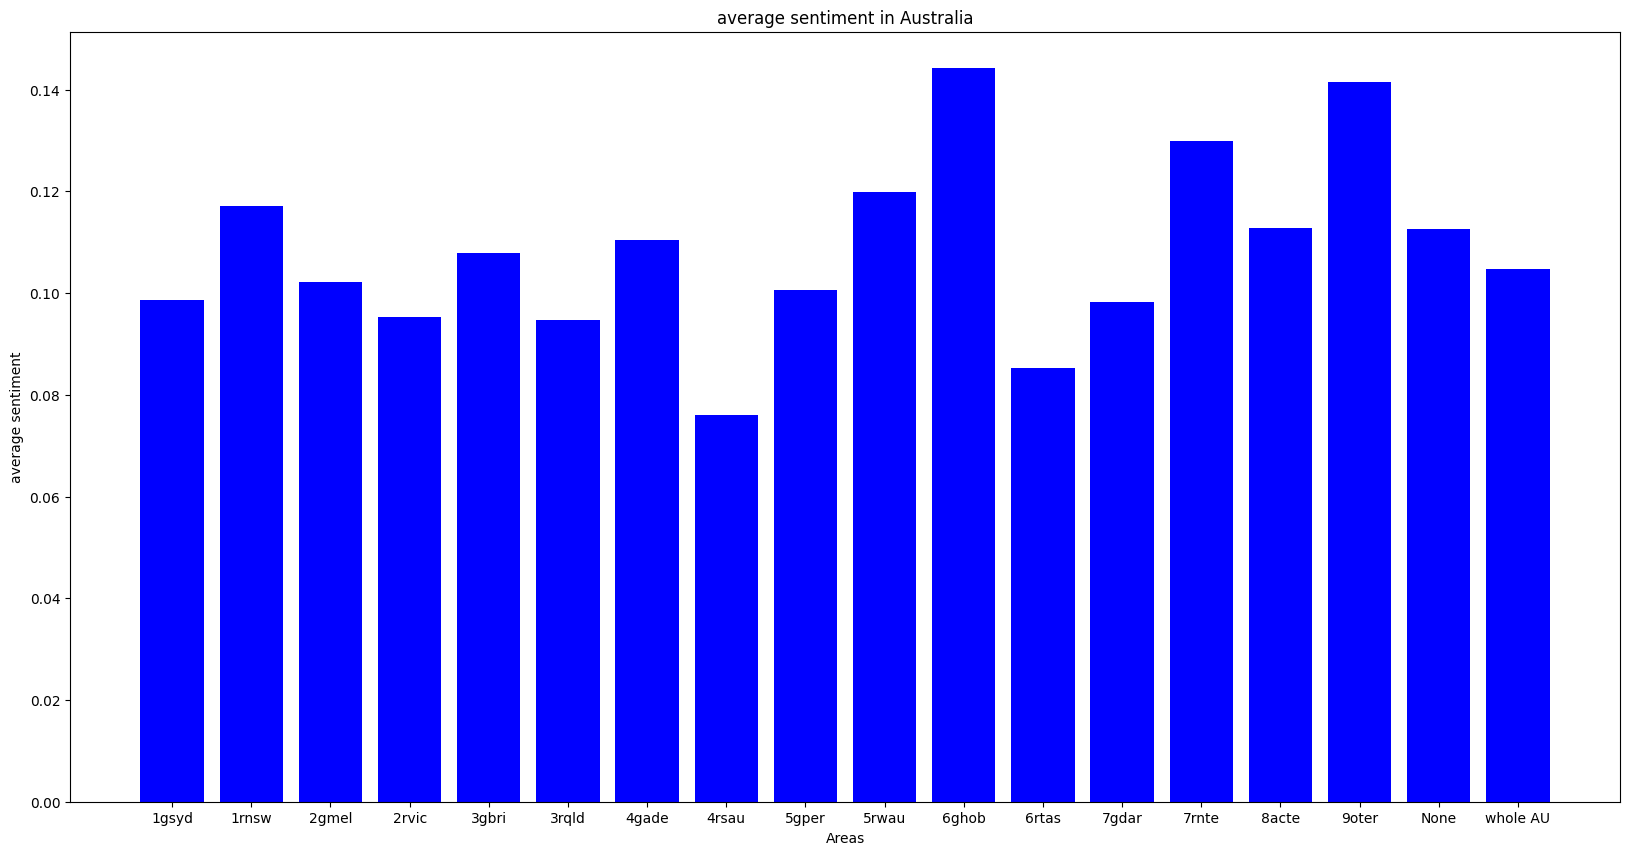

In [159]:
print(sorted_average_sentiment)
ave_who = sorted_average_sentiment.copy()
ave_who["whole AU"]=who_average_sen
plt.figure(figsize=(20, 10))
bar_chart(ave_who)

## income and sentiment

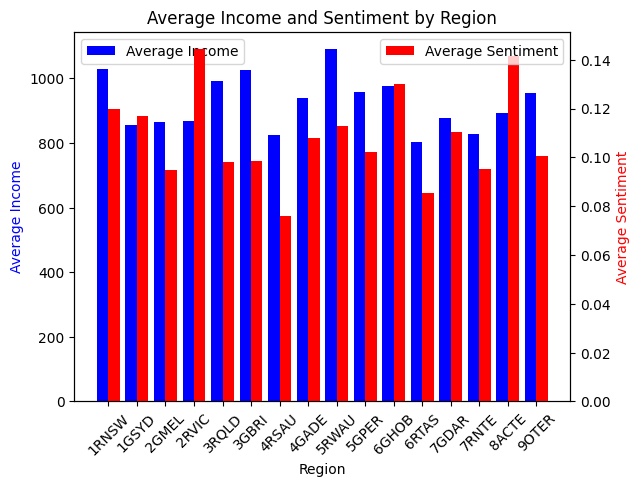

In [160]:
bi_group_bar_chat(area_sentiment_income)

## crash

In [161]:
import requests

def getfromurl(url):
    
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        formatted_json = json.dumps(json_data, indent=4)
        #print(formatted_json)
        return(formatted_json)
    else:
        print("Error:", response.status_code)
speed=getfromurl("http://127.0.0.1:9090/crash/field/speed_zone/para/all")
light=getfromurl("http://127.0.0.1:9090/crash/field/light_condition/para/all")
sev=getfromurl("http://127.0.0.1:9090/crash/field/severity/para/all")

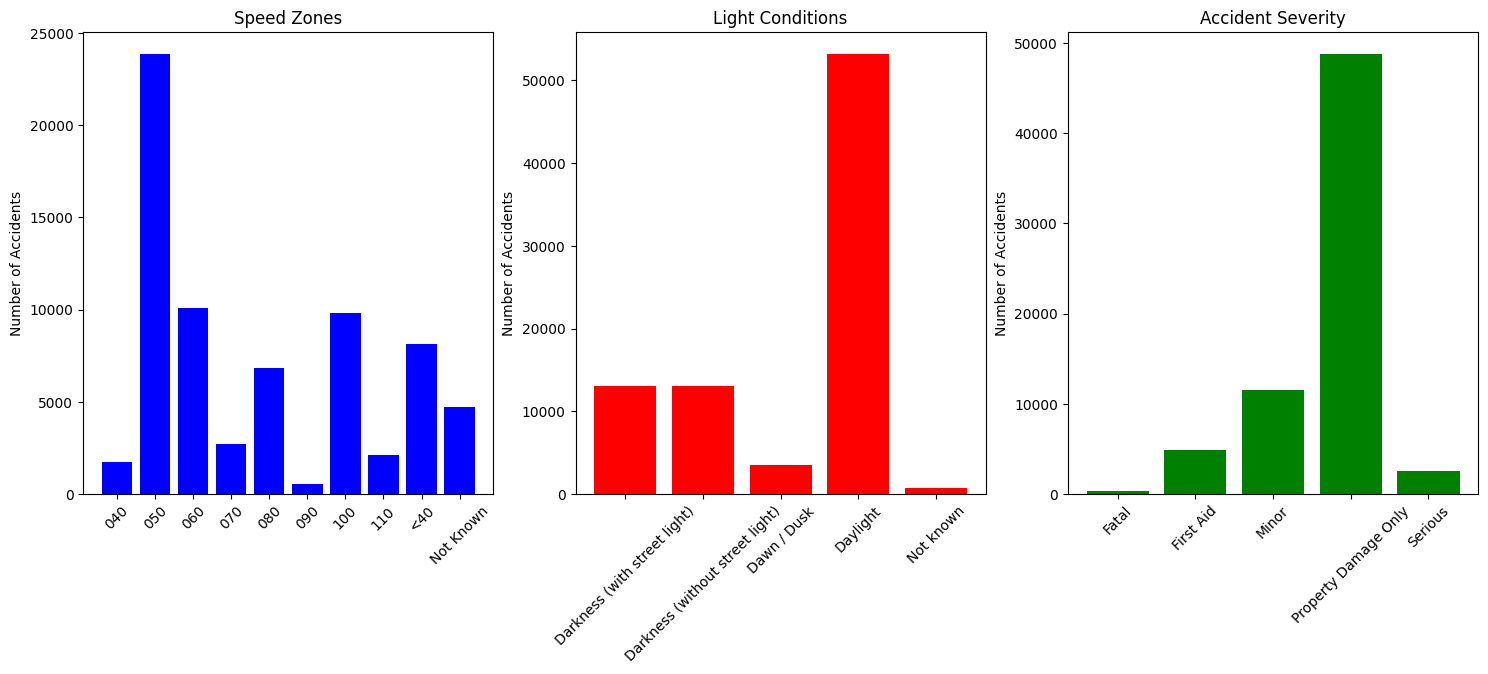

In [162]:
sub_bar_chart(speed,light,sev)